In [260]:
from datetime import datetime
from ecallisto_ng.plotting.plotting import plot_spectogram_mpl, fill_missing_timesteps_with_nan
from ecallisto_ng.data_processing.utils import elimwrongchannels, subtract_constant_background
import pandas as pd
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from ecallisto_ng.plotting.utils import (
    fill_missing_timesteps_with_nan,
)
from glob import glob
import torch
import pandas as pd
from typing import List

In [261]:
import scipy.signal
from scipy.ndimage import median_filter

def mean_filter(df, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size) / (kernel_size[0] * kernel_size[1])
    data = scipy.signal.convolve2d(df.to_numpy(), kernel, 'same')
    df.values[:] = data
    return df


def apply_median_filter(df, size=(3, 3)):
    data = median_filter(df.values, size)
    df.values[:] = data
    return df


In [262]:
start_datetime = datetime(2023, 9, 8, 0, 0, 0).strftime("%Y-%m-%d %H:%M:%S")
end_datetime = datetime(2023, 9, 8, 23, 59, 59).strftime("%Y-%m-%d %H:%M:%S")
data_folder = 'data_3'
filter = None
location = ['swiss', 'germany', 'austria', 'glasgow', 'egypt', 'ethiopia', 'denmark', 'spain', 'triest', 'krim']

In [263]:
files = glob(f"{data_folder}/*.parquet")

In [264]:
datas = [pd.read_parquet(file) for file in files] #if any(loc in file for loc in location)]

In [265]:
# Process data
data_processed = []
for data in datas:
    # Check that it has at least 100 columns
    if len(data.columns) < 100:
        continue
    if max([float(col) for col in data.columns]) > 150:
        continue
    try:
        # Cut away columns with value above x and below y
        columns = np.array([float(col) for col in data.columns])
        data = data.loc[:, (columns > 15) & (columns < 85)]
        data = fill_missing_timesteps_with_nan(data)
        data = elimwrongchannels(data)
        data = subtract_constant_background(data, 1000)
        if filter == 'median':
            data = apply_median_filter(data)
        elif filter == 'mean':
            data = mean_filter(data)
        else:
            pass
        # Cap min value to 0
        data[data < 0] = 0
        # Min max scaling to 0 and 1
        data = ((data - data.min()) / (data.max() - data.min()))
        data.fillna(0, inplace=True) 
        data_processed.append(data)
    except Exception as e:
        print(e)
        print(data.columns)

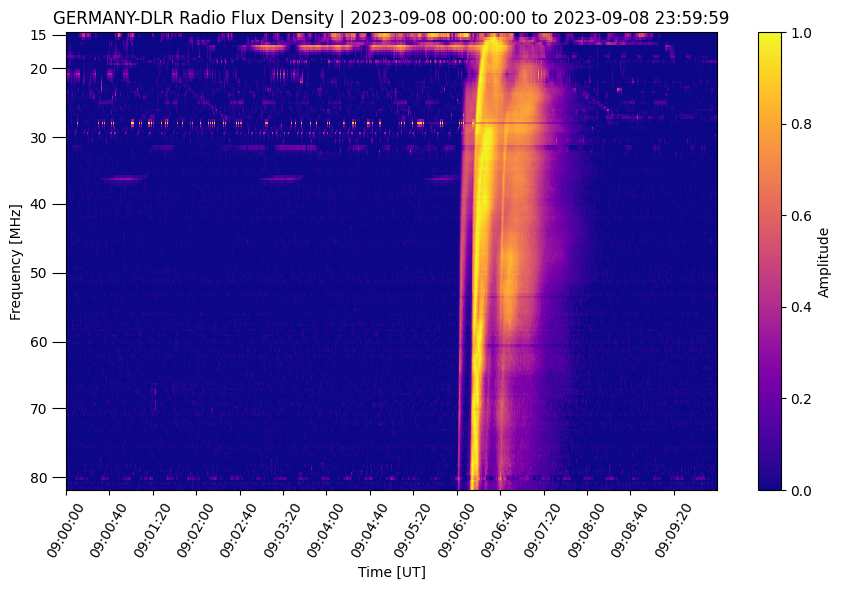

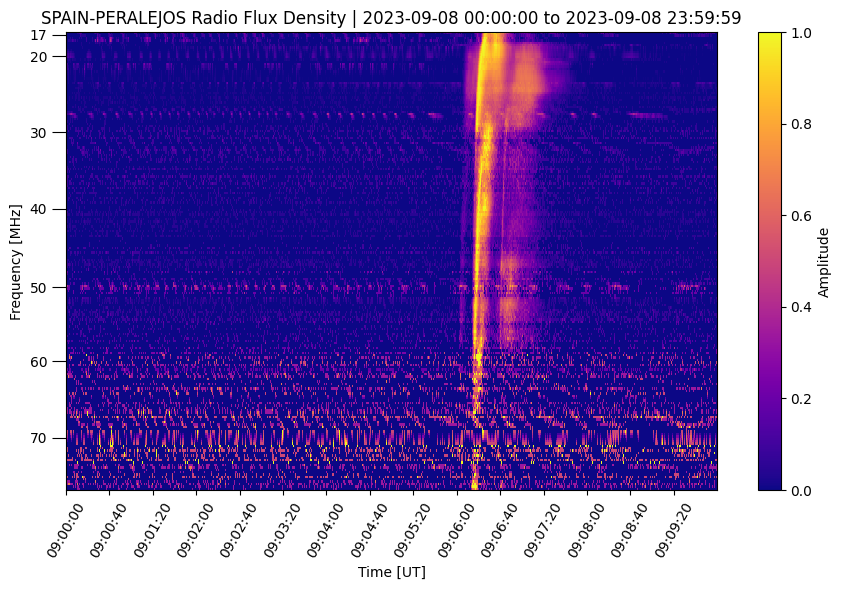

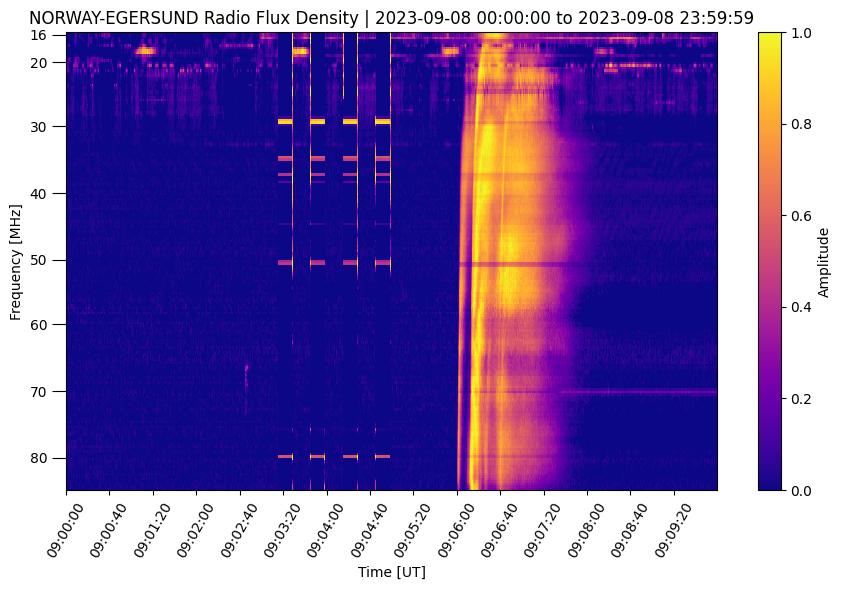

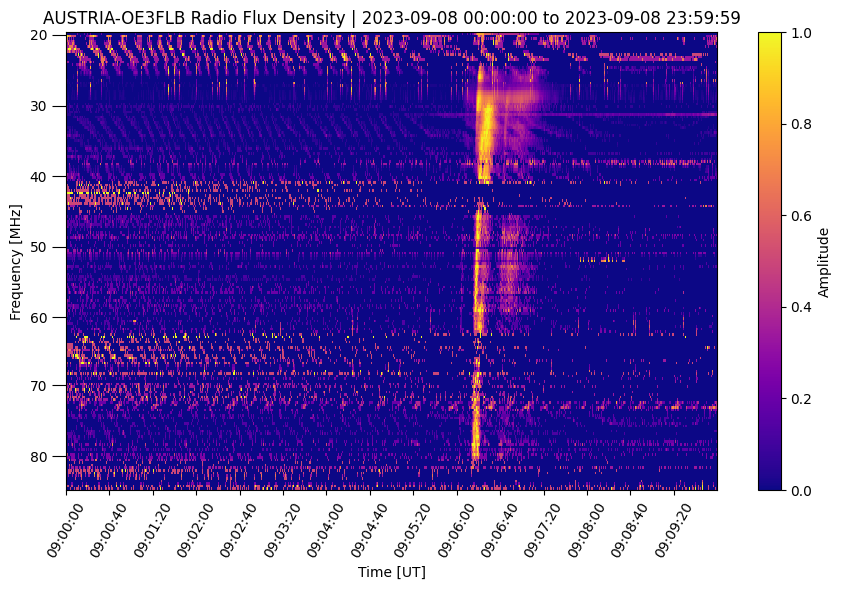

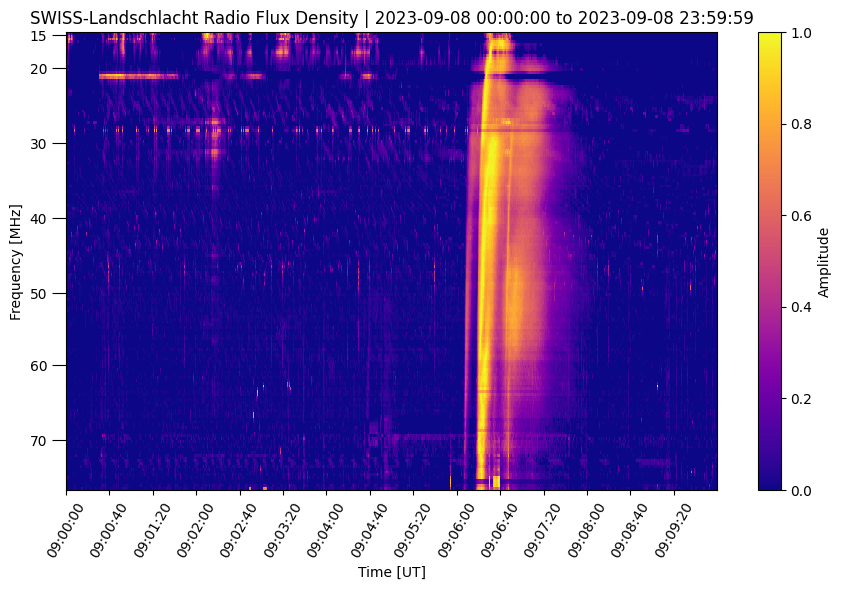

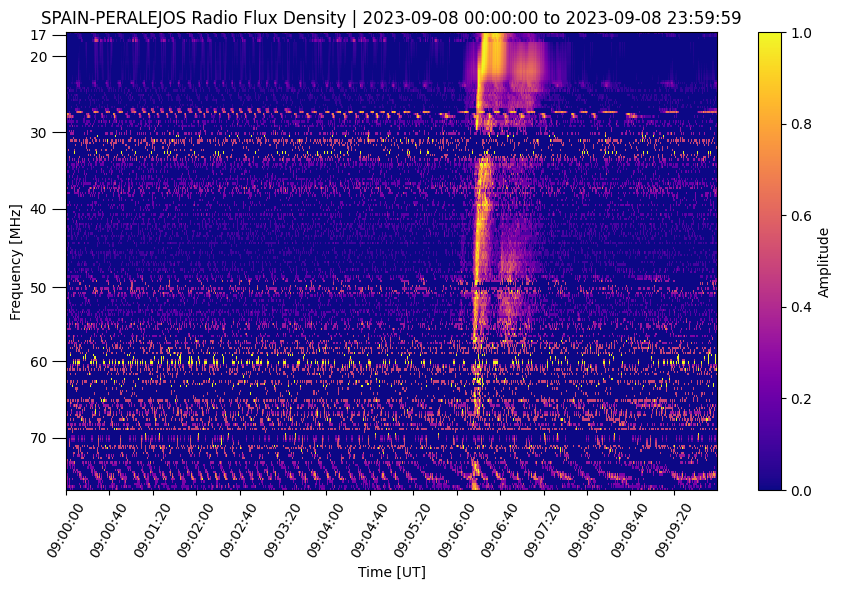

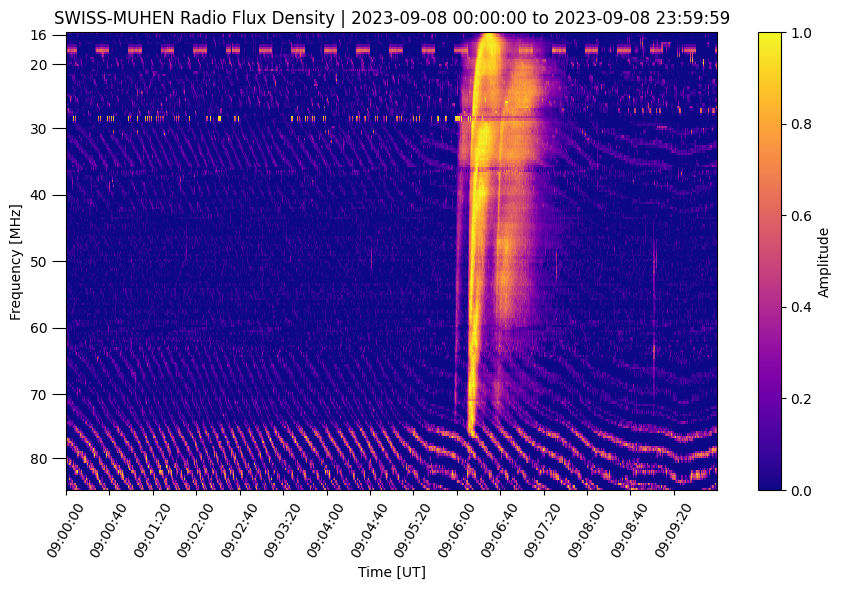

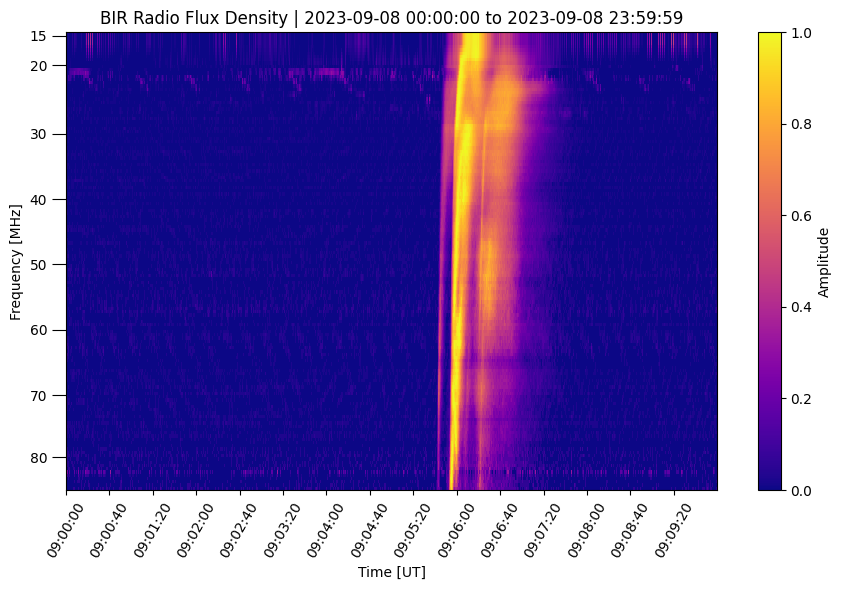

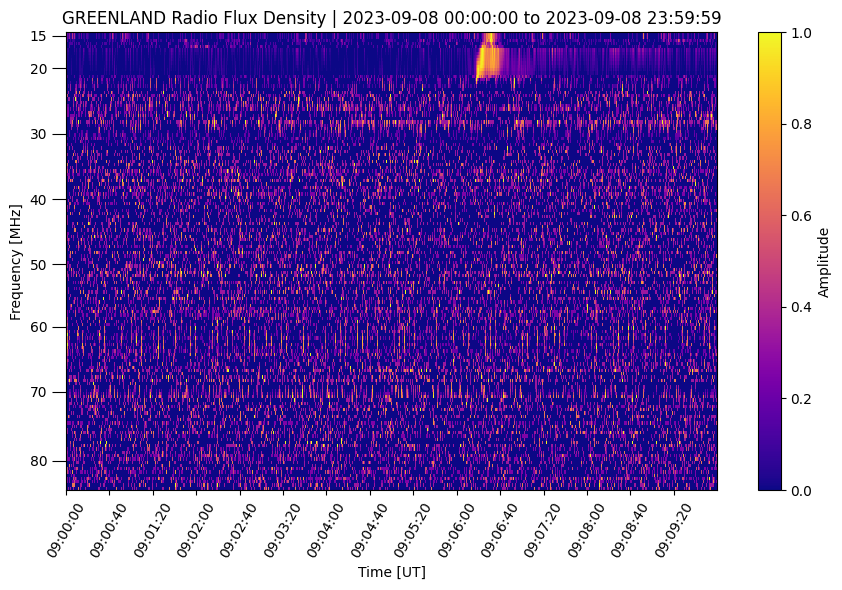

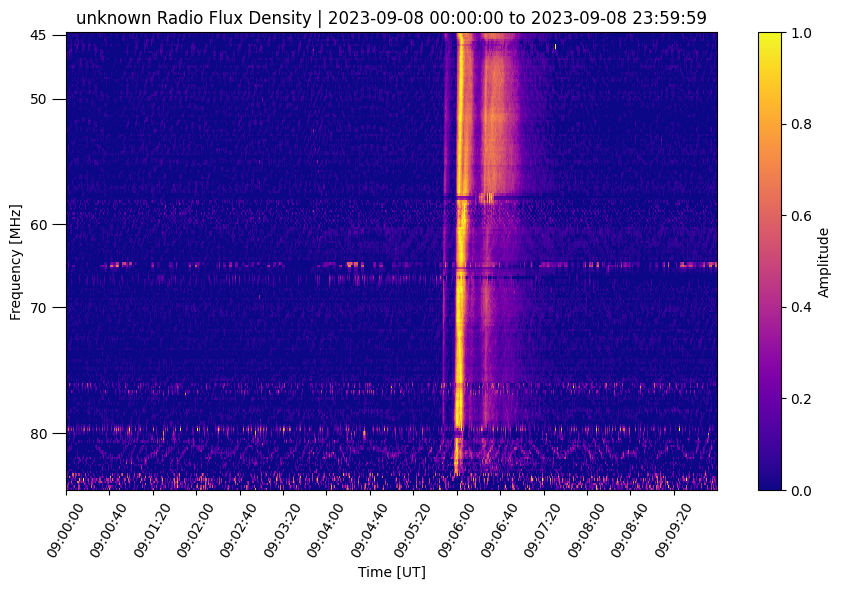

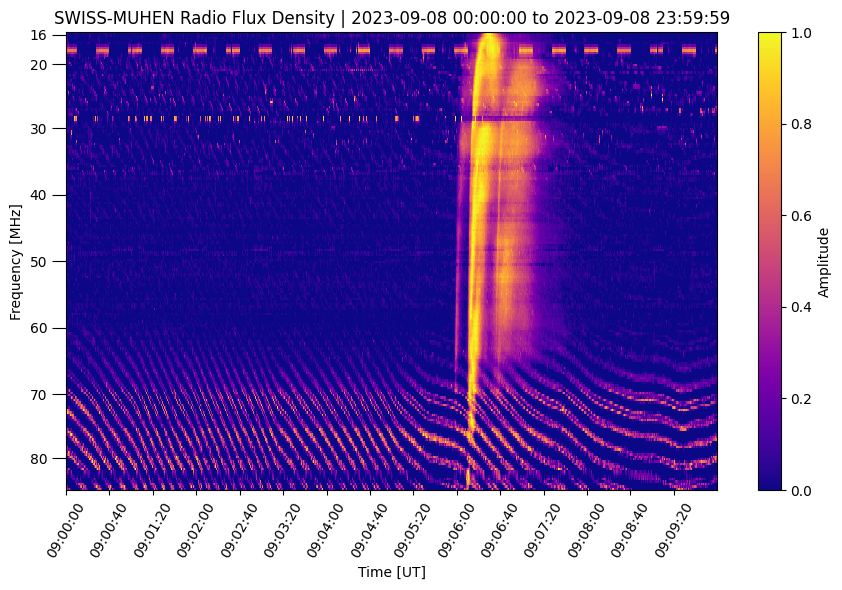

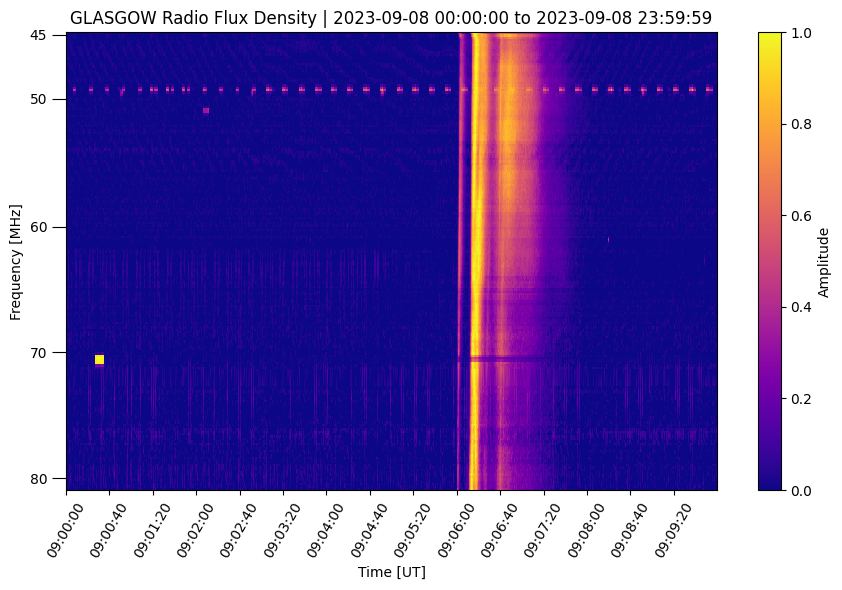

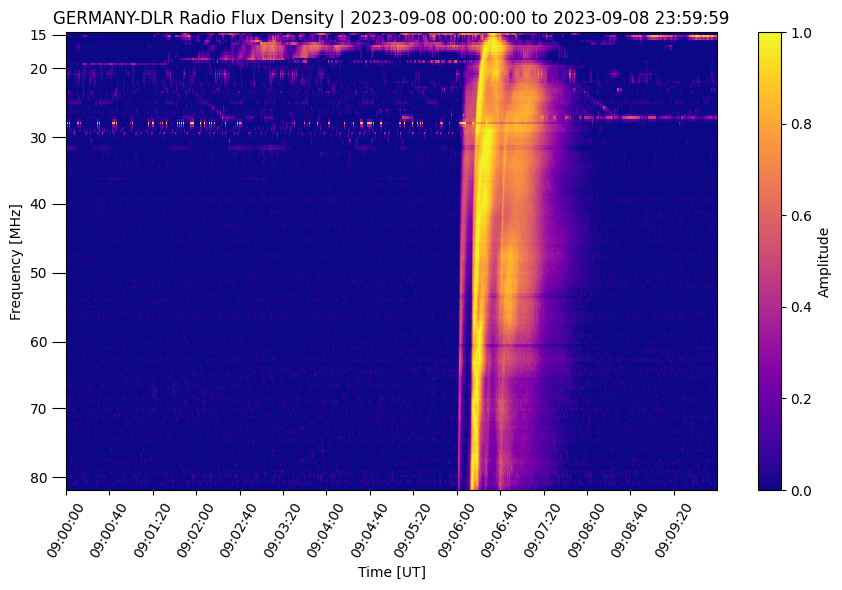

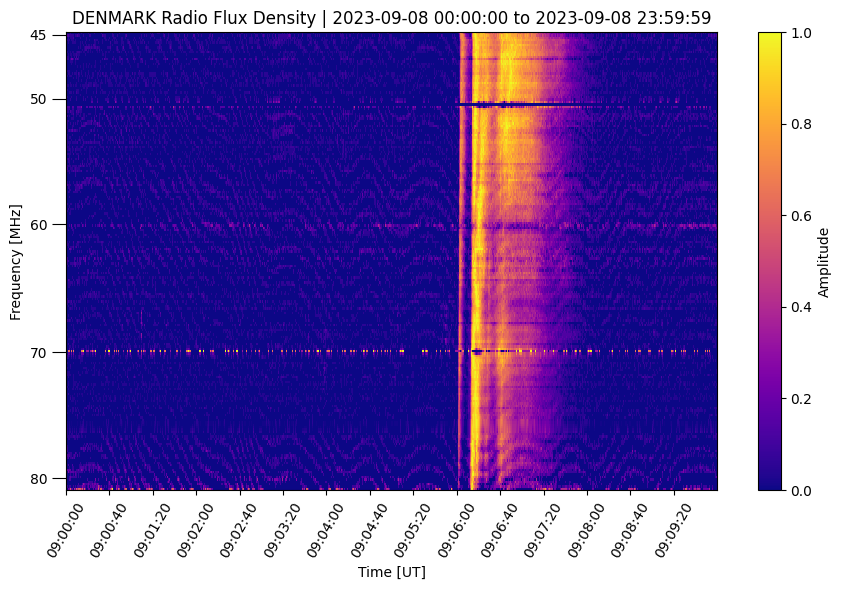

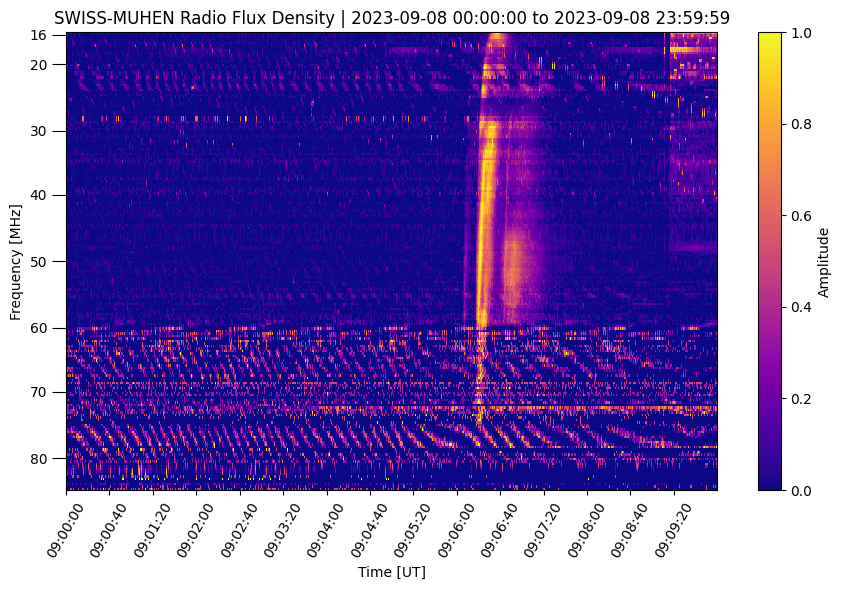

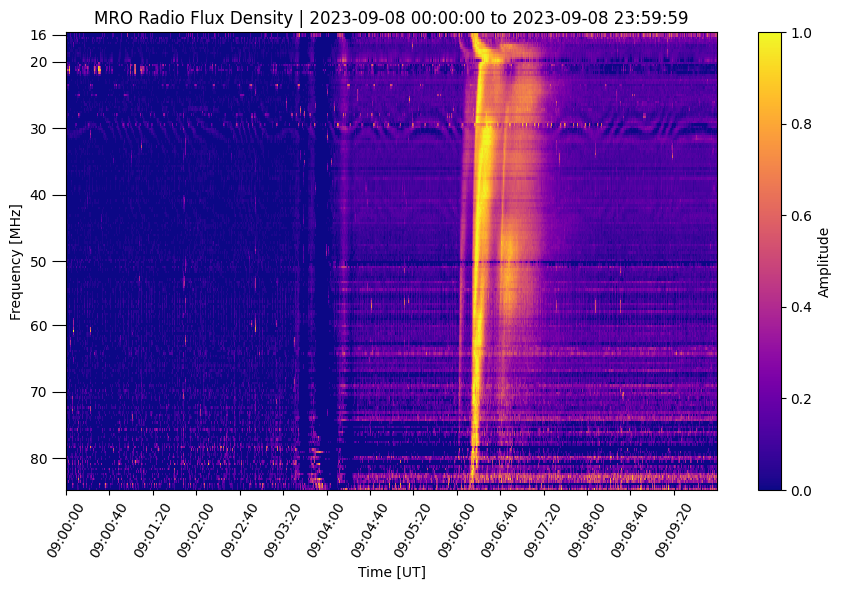

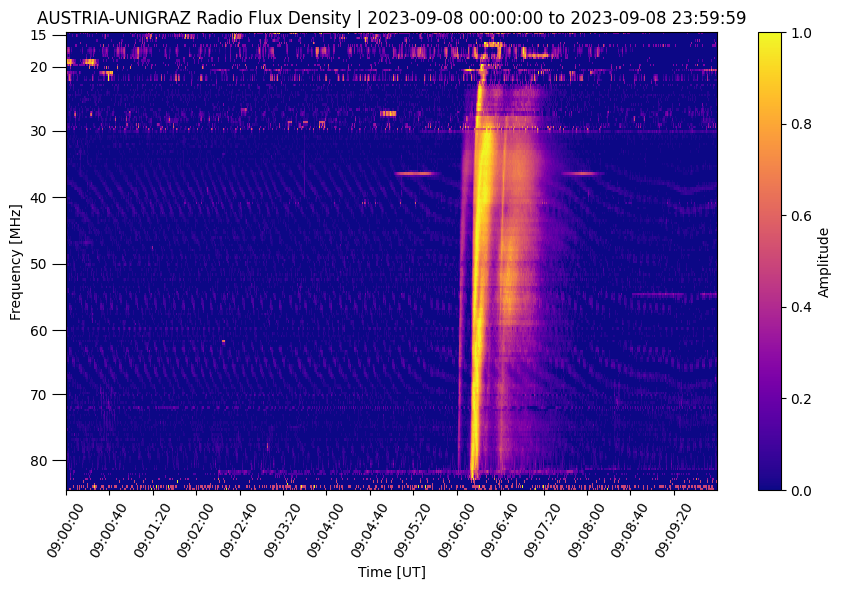

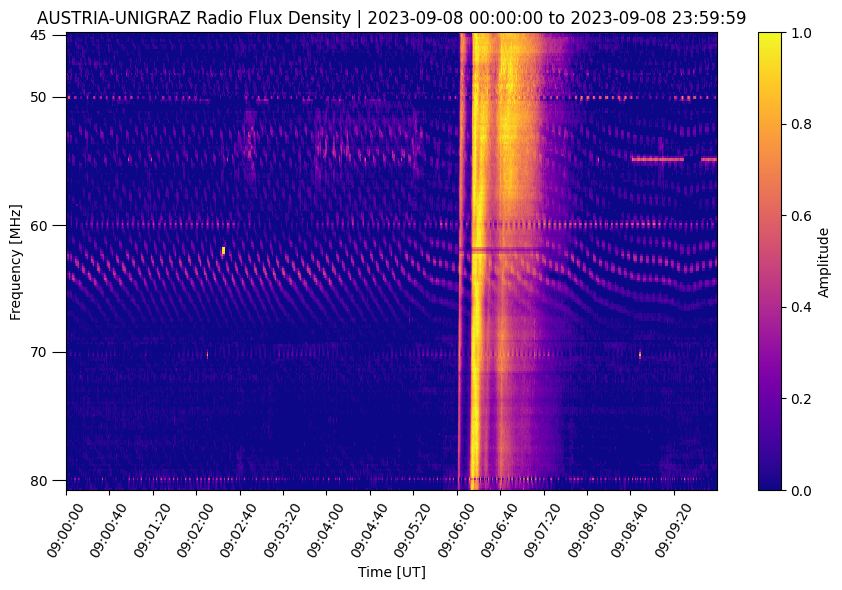

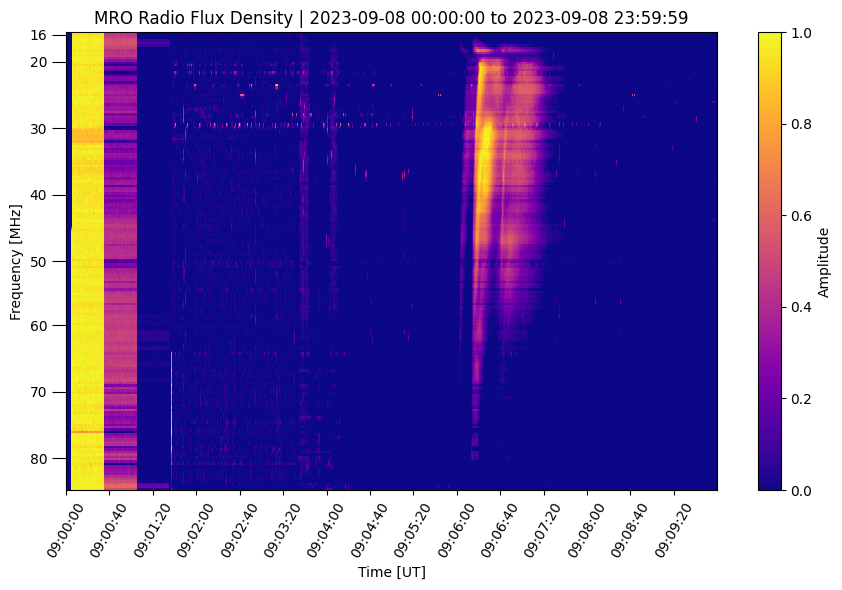

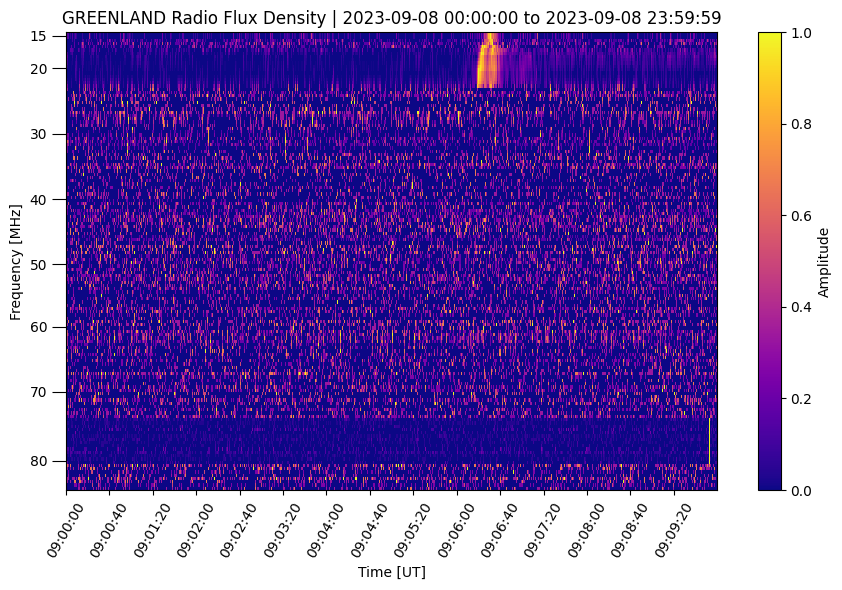

In [266]:
for data in data_processed:
    try:
        instr_name = data.attrs['INSTRUME']
    except:
        instr_name = 'unknown'
    fig = plot_spectogram_mpl(fill_missing_timesteps_with_nan(data), start_datetime=start_datetime, end_datetime=end_datetime, instrument_name=instr_name)

In [267]:
def make_times_match_spectograms(dfs: List[pd.DataFrame]):
    min_datetime = min([df.index.min() for df in dfs])
    print(min_datetime)
    max_datetime = max([df.index.max() for df in dfs])
    print(max_datetime)
    new_dfs = []
    for df in dfs:
        df = fill_missing_timesteps_with_nan(df, start_datetime=min_datetime, end_datetime=max_datetime)
        new_dfs.append(df)


    return new_dfs

def interpolate_columns(df: pd.DataFrame, all_columns: List[float]) -> pd.DataFrame:
    """Interpolate missing columns in a dataframe."""
    df = df.reindex(columns=all_columns)
    df.interpolate(method='linear', axis=1, inplace=True, limit_area='inside')
    return df

def make_frequencies_match_spectograms(dfs: List[pd.DataFrame]) -> List[pd.DataFrame]:
    # Gather all unique frequencies across all dataframes
    all_columns = sorted(list(set(float(col) for df in dfs for col in df.columns)))

    # To str agian
    all_columns = [str(col) for col in all_columns]

    # Interpolate missing columns for each dataframe
    new_dfs = [interpolate_columns(df, all_columns) for df in dfs]

    return new_dfs


In [268]:
def interpolate_columns(df: pd.DataFrame, all_columns: List[float]) -> pd.DataFrame:
    """Interpolate missing columns in a dataframe."""
    df = df.reindex(columns=all_columns)
    df.interpolate(method='linear', axis=1, inplace=True, limit_area='inside')
    return df

def make_frequencies_match_spectograms(dfs: List[pd.DataFrame]) -> List[pd.DataFrame]:
    # Gather all unique frequencies across all dataframes
    all_columns = sorted(list(set(float(col) for df in dfs for col in df.columns)))

    # To str agian
    all_columns = [str(col) for col in all_columns]

    # Interpolate missing columns for each dataframe
    new_dfs = [interpolate_columns(df, all_columns) for df in dfs]

    return new_dfs


In [269]:
data_processed = make_times_match_spectograms(data_processed)
data_processed = make_frequencies_match_spectograms(data_processed)

2023-09-28 09:00:00
2023-09-28 09:09:59.750000


In [283]:
data_torch = [torch.from_numpy(df.values) for df in data_processed]

In [284]:
def align_spectrograms_middle(spec1, spec2):
    # Sum intensity over the frequency axis
    summed_spec1 = torch.nansum(spec1, dim=1)
    summed_spec2 = torch.nansum(spec2, dim=1)
  
    # Extract the middle 50% of the second spectrogram
    middle2 = summed_spec2[int(0.25 * len(summed_spec2)):int(0.75 * len(summed_spec2))]
  
    # Compute cross-correlation
    cross_corr = F.conv1d(summed_spec1[None, None, :], middle2[None, None, :].flip(dims=[2]))
  
    # Find max correlation index
    shift = torch.argmax(cross_corr) - len(middle2)
  
    return shift.item()

def pairwise_cross_corr(spec_list):
    N = len(spec_list)
    cross_corr_matrix = torch.zeros(N, N)
    for i in range(N):
        for j in range(i+1, N):
            shift = align_spectrograms_middle(spec_list[i], spec_list[j])
            cross_corr_matrix[i][j] = shift
            cross_corr_matrix[j][i] = -shift  # Reverse shift for j relative to i
    return cross_corr_matrix

def find_best_reference(cross_corr_matrix):
    # Sum of absolute shifts for each spectrogram
    abs_sum_shifts = torch.sum(torch.abs(cross_corr_matrix), dim=1)
    
    # Find the index with the minimum sum of shifts
    ref_idx = torch.argmin(abs_sum_shifts)
    
    return ref_idx

def align_to_reference(cross_corr_matrix):
    ref_idx = find_best_reference(cross_corr_matrix)
    
    # Shifts needed to align all to the reference spectrogram
    shifts_to_ref = cross_corr_matrix[ref_idx]
    
    return ref_idx, shifts_to_ref

def shift_spectrograms(spec_list, shifts):
    shifted_spectrograms = []
    for shift_, spec in zip(shifts, spec_list):

        shifted_spec = spec.shift(periods=int(shift_))
        shifted_spectrograms.append(shifted_spec)
    return shifted_spectrograms

In [285]:
cross_corr_matrix = pairwise_cross_corr(data_torch)

In [286]:
# Find the best reference and align all to it
ref_idx, shifts_to_ref = align_to_reference(cross_corr_matrix)

In [287]:
def shift_spectrograms(spec_list, shifts):
    shifted_spectrograms = []
    for shift_, spec in zip(shifts, spec_list):

        shifted_spec = spec.shift(periods=int(shift_))
        shifted_spectrograms.append(shifted_spec)
    return shifted_spectrograms

In [288]:
shifted_specs = shift_spectrograms(data_processed, shifts_to_ref)

/tmp/ipykernel_276895/3583251643.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


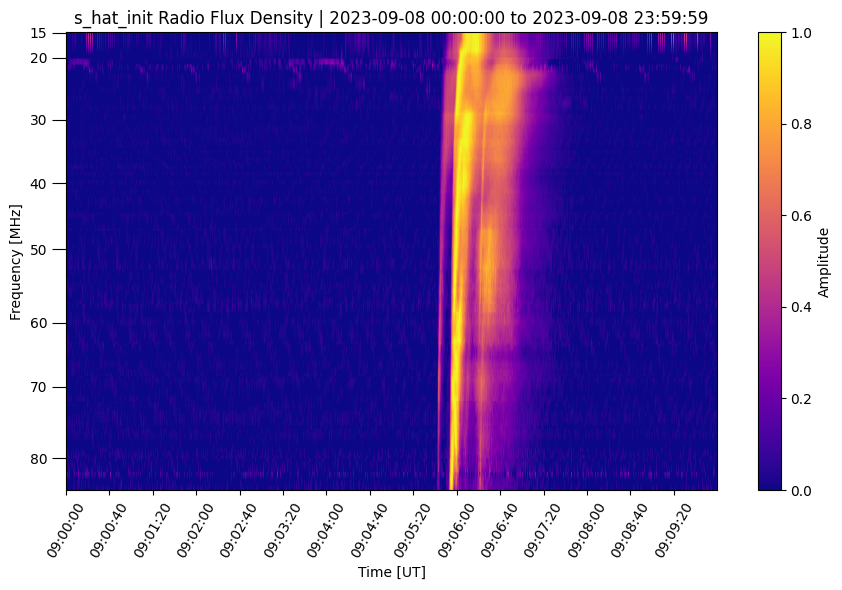

In [291]:
# plot
data_quantile_df = pd.DataFrame(shifted_specs[ref_idx], columns=data_processed[1].columns, index=data_processed[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

/tmp/ipykernel_276895/2739764178.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


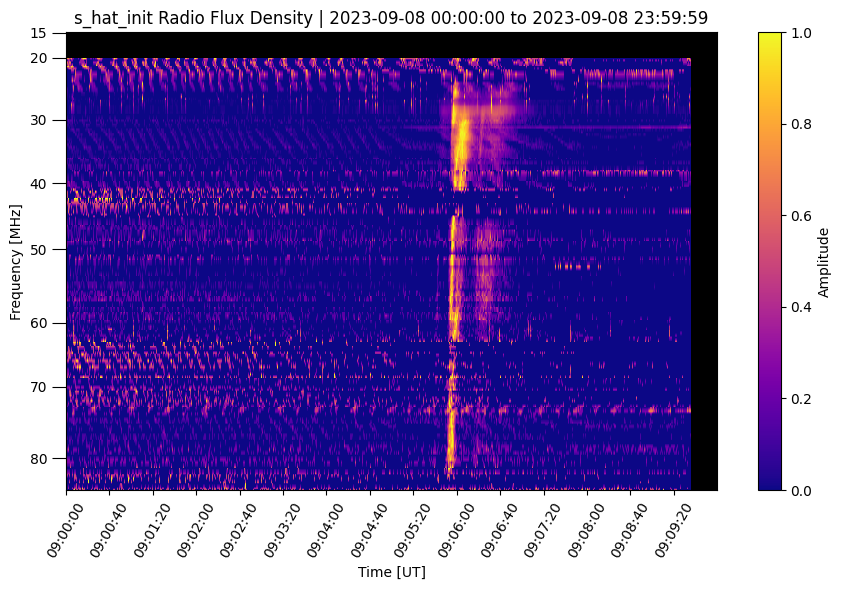

In [294]:
# plot
data_quantile_df = pd.DataFrame(shifted_specs[3].shift(-100), columns=data_processed[1].columns, index=data_processed[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

In [238]:
# Correlation with reference spectogram
def correlation_with_reference(spec_list, ref_idx):
    ref_spec = np.sum(spec_list[ref_idx], axis=1)
    correlations = []
    for spec in spec_list:
        correlations.append(np.corrcoef(ref_spec, np.sum(spec, axis=1))[0, 1])
    return correlations

In [239]:
correlation_with_reference(shifted_specs, ref_idx)

[0.7545376967259924,
 0.7140513558539643,
 0.7349655771620277,
 0.5762864906807269,
 0.6741554002709231,
 0.671650856343142,
 0.7771242454111259,
 0.9999999999999999,
 0.12985220707300016,
 0.9012470882227922,
 0.7782643199170222,
 0.7375040109729482,
 0.748951748260133,
 0.7394739448321433,
 0.6513350553079299,
 0.7171714240924861,
 0.7445684903534457,
 0.750363434880495,
 0.15395558084834698,
 0.1987832304078044]

/tmp/ipykernel_276895/72946755.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


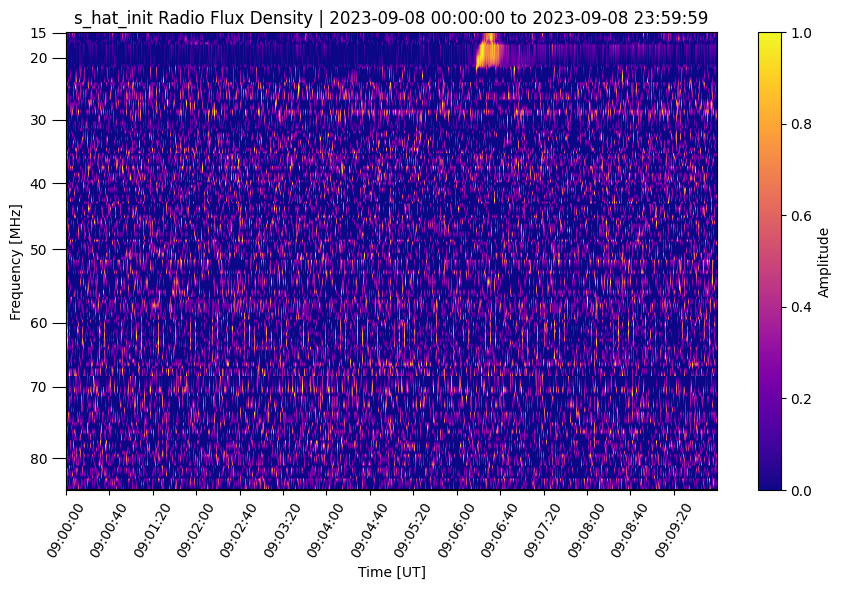

In [316]:
# plot
data_quantile_df = pd.DataFrame(shifted_specs[8], columns=data_processed[1].columns, index=data_processed[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

In [309]:
torch_shifted = torch.stack([torch.from_numpy(df.values) for df in shifted_specs])
torch_quantile = torch.nanquantile(torch_shifted, 0.4, dim=0)

/tmp/ipykernel_276895/1954146109.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


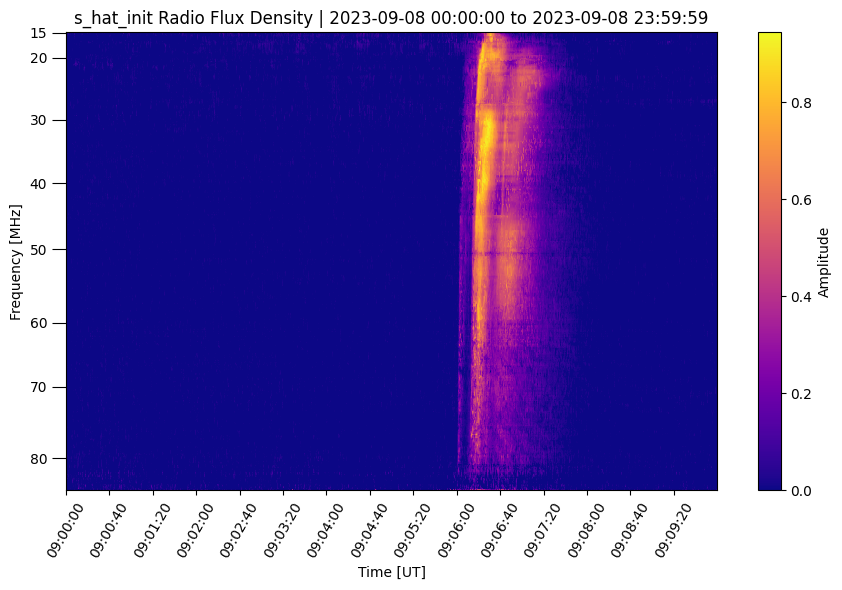

In [310]:
# plot
data_quantile_df = pd.DataFrame(torch_quantile, columns=data_processed[1].columns, index=data_processed[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

In [313]:
# Create for all quantiles 
torch_quantiles = []
for i in np.arange(0.1, 1, 0.1):
    torch_quantiles.append(torch.nanquantile(torch_shifted, i, dim=0))

In [314]:
from ipywidgets import interact
import pandas as pd

@interact(index=(0, len(torch_quantiles) - 1))
def plot_spectrogram(index=0):
    s_hat_df = pd.DataFrame(torch_quantiles[index], columns=data_processed[1].columns, index=data_processed[1].index)
    plot_spectogram_mpl(s_hat_df, 's_hat', start_datetime, end_datetime).show()


interactive(children=(IntSlider(value=0, description='index', max=8), Output()), _dom_classes=('widget-interac…